# **Step 1**: _Hello World_

## Installing Deep Lake

Deep Lake can be installed via `pip`.

In [1]:
from IPython.display import clear_output

!pip3 install deeplake==3.8.27

clear_output()

In [2]:
# Temporary fix for using Deep Lake Storage in Colab
with open('/etc/resolv.conf', 'w') as file:
  file.write("nameserver 8.8.8.8")

**By default, Deep Lake does not install dependencies for audio, video, google-cloud, and other features. Details on installation options are available [here](https://docs.deeplake.ai/en/latest/Installation.html).**

## Fetching your first Deep Lake dataset

Begin by loading in [MNIST](https://en.wikipedia.org/wiki/MNIST_database), the hello world dataset of machine learning.

First, load the `Dataset` by pointing to its storage location. Datasets hosted on Activeloop are typically identified by the namespace of the organization followed by the dataset name: `activeloop/mnist-train`.

In [3]:
import deeplake

dataset_path = 'hub://activeloop/mnist-train'
ds = deeplake.load(dataset_path) # Returns a Deep Lake Dataset but does not download data locally

/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.0) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mnist-train



/

hub://activeloop/mnist-train loaded successfully.



## Reading Samples From a Deep Lake Dataset

Data is not immediately read into memory because Deep Lake operates [lazily](https://en.wikipedia.org/wiki/Lazy_evaluation). You can fetch data by calling the `.numpy()` method, which reads data into a NumPy array.


In [4]:
# Indexing
img = ds.images[0].numpy()              # Fetch the 1st image and return a NumPy array
label = ds.labels[0].numpy(aslist=True) # Fetch the 1st label and store it as a
                                        # as a list

text_labels = ds.labels[0].data()['text'] # Fetch the first labels and return them as text

# Slicing
imgs = ds.images[0:100].numpy() # Fetch 100 images and return a NumPy array
                                # The method above produces an exception if
                                # the images are not all the same size

labels = ds.labels[0:100].numpy(aslist=True) # Fetch 100 labels and store
                                             # them as a list of NumPy arrays

In [5]:
print('label is {}'.format(text_labels))

label is ['5']


Congratulations, you've got Deep Lake working on your local machine! 🤓

# **Step 2**: _Creating Deep Lake Datasets_
*Creating and storing Deep Lake Datasets.*

This guide creates Deep Lake datasets locally. You may create datasets in the Activeloop cloud by [registering](https://app.activeloop.ai/register), creating an API token, and replacing the local paths below with the path to a dataset in your Deep Lake organization `hub://organization_name/dataset_name`

You don't have to worry about uploading datasets after you've created them. They are automatically synchronized with [wherever they are being stored](https://docs.activeloop.ai/authentication-overview).

## Manual Creation

Let's follow along with the example below to create our first dataset. First, download and unzip the small classification dataset below called the *animals dataset*.

In [6]:
# Download dataset
from IPython.display import clear_output
!wget https://github.com/activeloopai/examples/raw/main/colabs/starting_data/animals.zip
clear_output()

In [7]:
# Unzip to './animals' folder
!unzip -qq /content/animals.zip

The dataset has the following folder structure:

animals
- cats
  - image_1.jpg
  - image_2.jpg
- dogs
  - image_3.jpg
  - image_4.jpg

Now that you have the data, you can **create a Deep Lake `Dataset`** and initialize its tensors. Running the following code will create a Deep Lake dataset inside of the `./animals_dl` folder.


In [8]:
import deeplake
from PIL import Image
import numpy as np
import os

ds = deeplake.empty('./animals_dl') # Creates the dataset

./animals_dl loaded successfully.


Next, let's inspect the folder structure for the source dataset `'./animals'` to find the class names and the files that need to be uploaded to the Deep Lake dataset.

In [9]:
# Find the class_names and list of files that need to be uploaded
dataset_folder = './animals'

# Find the subfolders, but filter additional files like DS_Store that are added on Mac machines.
class_names = [item for item in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, item))]

files_list = []
for dirpath, dirnames, filenames in os.walk(dataset_folder):
    for filename in filenames:
        files_list.append(os.path.join(dirpath, filename))

Next, let's **create the dataset tensors and upload metadata**. Check out our page on [Storage Synchronization](https://docs.activeloop.ai/how-it-works/storage-synchronization) for details about the `with` syntax below.


In [10]:
with ds:
  # Create the tensors with names of your choice.
  ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
  ds.create_tensor('labels', htype = 'class_label', class_names = class_names)

  # Add arbitrary metadata - Optional
  ds.info.update(description = 'My first Deep Lake dataset')
  ds.images.info.update(camera_type = 'SLR')

**Note:** Specifying [htype](https://docs.activeloop.ai/dataset-visualization/data-type-htype) and `dtype` is not required, but it is highly recommended in order to optimize performance, especially for large datasets. Use `dtype` to specify the numeric type of tensor data, and use `htype` to specify the underlying data structure.

Finally, let's **populate the data** in the tensors.         

In [11]:
with ds:
    # Iterate through the files and append to Deep Lake dataset
    for file in files_list:
        label_text = os.path.basename(os.path.dirname(file))
        label_num = class_names.index(label_text)

        #Append data to the tensors
        ds.append({'images': deeplake.read(file), 'labels': np.uint32(label_num)})

**Note:** `ds.append({'images': deeplake.read(path)})` is functionally equivalent to `ds.append({'images': PIL.Image.fromarray(path)})`. However, the `deeplake.read()` method is significantly faster because it does not decompress and recompress the image if the compression matches the `sample_compression` for that tensor. Further details are available in the next section.

**Note:** In order to maintain proper indexing across tensors, `ds.append({...})` requires that you to append to all tensors in the dataset. If you wish to skip tensors during appending, please use `ds.append({...}, skip_ok = True)` or append to a single tensor using `ds.tensor_name.append(...)`.

Check out the first label and image from this dataset. More details about Accessing Data are available in **Step 4**.

In [12]:
ds.labels.info.class_names[ds.labels[0].numpy()[0]]

'dogs'

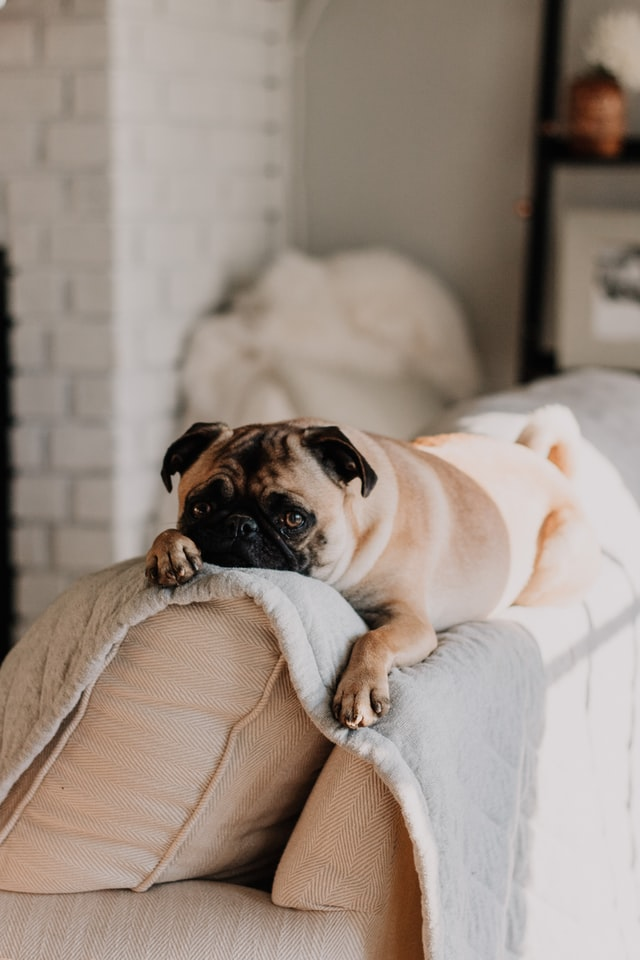

In [13]:
Image.fromarray(ds.images[0].numpy())

You can print a summary of the dataset structure using:


In [14]:
ds.summary()

Dataset(path='./animals_dl', tensors=['images', 'labels'])

 tensor      htype             shape           dtype  compression
 -------    -------           -------         -------  ------- 
 images      image     (4, 427:1026, 640, 3)   uint8    jpeg   
 labels   class_label         (4, 1)          uint32    None   


## Automatic Creation

If your source data conforms to one of the formats below, you can ingest them directly with 1 line of code.
* YOLO
* [COCO](https://docs.deeplake.ai/en/latest/deeplake.html#deeplake.ingest_coco)
*Classifications

For example, the above animals dataset can be converted to Deep Lake format using:

In [15]:
src = "./animals"
dest = './animals_dl_auto'

ds = deeplake.ingest_classification(src, dest)

Evaluating ingest_classification: 100%|██████████| 4/4 [00:00<00:00

Synchronizing class labels...



Evaluating class_label_sync: 100%|██████████| 4/4 [00:00<00:00
Evaluating ingest_classification: 100%|██████████| 4/4 [00:00<00:00



Ingestion Complete. No files were skipped.




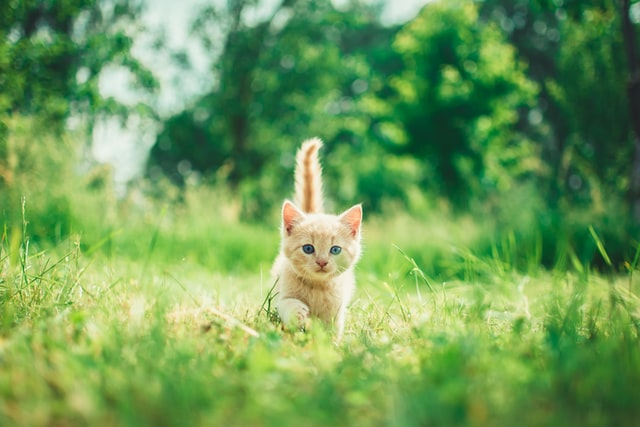

In [16]:
Image.fromarray(ds.images[0].numpy())

**Note**: Automatic creation currently supports image classification datasets where classes are separated by folder, though support for other dataset types is continually being added.

## Creating Tensor Hierarchies

Often it's important to create tensors hierarchically, because information between tensors may be inherently coupled—such as bounding boxes and their corresponding labels. Hierarchy can be created using tensor `groups`:

In [17]:
ds = deeplake.empty('./groups_test') # Creates the dataset

# Create tensor hierarchies
ds.create_group('my_group')
ds.my_group.create_tensor('my_tensor')

# Alternatively, a group can us created using create_tensor with '/'
ds.create_tensor('my_group_2/my_tensor') # Automatically creates the group 'my_group_2'

./groups_test loaded successfully.


Tensor(key='my_group_2/my_tensor')

Tensors in groups are accessed via:

In [18]:
ds.my_group.my_tensor

#OR

ds['my_group/my_tensor']

Tensor(key='my_group/my_tensor')

For more detailed information regarding accessing datasets and their tensors, check out **Step 4**.

# **Step 3**: _Understanding Compression_

*Using compression to achieve optimal performance.*

**Data in Deep Lake can be stored in raw uncompressed format. However, compression is highly recommended for achieving optimal performance in terms of speed and storage.**


Compression is specified separately for each tensor, and it can occur at the `sample` or `chunk` level. For example, when creating a tensor for storing images, you can choose the compression technique for the image samples using the `sample_compression` input:

In [19]:
import deeplake

# Set overwrite = True for re-runability
ds = deeplake.empty('./compression_test', overwrite = True)

ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')

./compression_test loaded successfully.


Tensor(key='images')

In this example, every image added in subsequent `.append(...)` calls is compressed using the specified `sample_compression` method.

### **Choosing the Right Compression**

There is no single answer for choosing the right compression, and the tradeoffs are described in detail in the next section. However, good rules of thumb are:



1.   For data that has application-specific compressors (`image`, `audio`, `video`,...), choose the sample_compression technique that is native to the application such as `jpg`, `mp3`, `mp4`,...
2.   For other data containing large samples (i.e. large arrays with >100 values), `lz4` is a generic compressor that works well in most applications. `lz4` can be used as a `sample_compression` or `chunk_compression`. In most cases, `sample_compression` is sufficient, but in theory, `chunk_compression` produces slightly smaller data.
3.   For other data containing small samples (i.e. labels with <100 values), it is not necessary to use compression.

### **Compression Tradeoffs**

**Lossiness -** Certain compression techniques are lossy, meaning that there is irreversible information loss when compressing the data. Lossless compression is less important for data such as images and videos, but it is critical for label data such as numerical labels, binary masks, and segmentation data.


**Memory -** Different compression techniques have substantially different memory footprints. For instance, png vs jpeg compression may result in a 10X difference in the size of a Deep Lake dataset.


**Runtime -** The primary variables affecting download and upload speeds for generating usable data are the network speed and available compute power for processing the data . In most cases, the network speed is the limiting factor. Therefore, the highest end-to-end throughput for non-local applications is achieved by maximizing compression and utilizing compute power to decompress/convert the data to formats that are consumed by deep learning models (i.e. arrays).


**Upload Considerations -** When applicable, the highest uploads speeds can be achieved when the  `sample_compression` input matches the compression of the source data, such as:

In [20]:
# sample_compression is "jpg" and appended image is "jpeg"
ds.create_tensor('images_jpg', htype = 'image', sample_compression = 'jpg')
ds.images_jpg.append(deeplake.read('./animals/dogs/image_3.jpg'))

In this case, the input data is a `.jpg`, and the Deep Lake `sample_compression` is `jpg`.

However, a mismatch between compression of the source data and sample_compression in Deep Lake results in significantly slower upload speeds, because Deep Lake must decompress the source data and recompress it using the specified `sample_compression` before saving.

In [21]:
# sample_compression is "jpg" and appended image is "jpeg"
ds.create_tensor('images_png', htype = 'image', sample_compression = 'png')
ds.images_png.append(deeplake.read('./animals/dogs/image_3.jpg'))

**NOTE:** Due to the computational costs associated with decompressing and recompressing data, it is important that you consider the runtime implications of uploading source data that is compressed differently than the specified sample_compression.

# **Step 4**: _Accessing Data_
_Accessing and loading Deep Lake Datasets._

## Loading Datasets

Deep Lake Datasets can be loaded and created in a variety of storage locations with minimal configuration.

In [22]:
import deeplake

In [23]:
# Local Filepath
ds = deeplake.load('./animals_dl') # Dataset created in Step 2 in this Colab Notebook

./animals_dl loaded successfully.



In [24]:
# S3
# ds = deeplake.load('s3://my_dataset_bucket', creds={...})

In [25]:
# Public Dataset hosted by Activeloop
## Activeloop Storage - See Step 6
ds = deeplake.load('hub://activeloop/k49-train')

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/k49-train



\

hub://activeloop/k49-train loaded successfully.



In [26]:
# Dataset in another organization on Activeloop
# ds = deeplake.load('hub://organization_name/dataset_name')

**Note:** Since `ds = deeplake.dataset(path)` can be used to both create and load datasets, you may accidentally create a new dataset if there is a typo in the path you provided while intending to load a dataset. If that occurs, simply use `ds.delete()` to remove the unintended dataset permanently.

## Referencing Tensors

Deep Lake allows you to reference specific tensors using keys or via the `.` notation outlined below.


**Note:** data is still not loaded by these commands.

In [27]:
ds = deeplake.dataset('hub://activeloop/k49-train')

-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/k49-train



|

hub://activeloop/k49-train loaded successfully.



In [28]:
### NO HIERARCHY ###
ds.images # is equivalent to
ds['images']

ds.labels # is equivalent to
ds['labels']

### WITH HIERARCHY ###
# ds.localization.boxes # is equivalent to
# ds['localization/boxes']

# ds.localization.labels # is equivalent to
# ds['localization/labels']

Tensor(key='labels')

## Accessing Data

Data within the tensors is loaded and accessed using the `.numpy()` command:

In [29]:
# Indexing
img = ds.images[0].numpy()              # Fetch the 1st image and return a NumPy array
label = ds.labels[0].numpy(aslist=True) # Fetch the 1st label and store it as a
                                        # as a list

# frame = ds.videos[0][4].numpy()   # Fetch the 5th frame in the 1st video
                                    # and return a NumPy array

text_labels = ds.labels[0].data()['value'] # Fetch the first labels and return them as text

# Slicing
imgs = ds.images[0:100].numpy() # Fetch 100 images and return a NumPy array
                                # The method above produces an exception if
                                # the images are not all the same size

labels = ds.labels[0:100].numpy(aslist=True) # Fetch 100 labels and store
                                             # them as a list of NumPy arrays

**Note:** The `.numpy()` method will produce an exception if all samples in the requested tensor do not have a uniform shape. If that's the case, running `.numpy(aslist=True)` solves the problem by returning a list of NumPy arrays, where the indices of the list correspond to different samples.

## Updating Data

In [30]:
ds = deeplake.load('./animals_dl') # Dataset created in Step 2 in this Colab Notebook

./animals_dl loaded successfully.



Existing data in a Deep Lake dataset can be updated using:

In [31]:
ds.images[1] = deeplake.read('https://i.postimg.cc/Yq2SNz9J/photo-1534567110243-8875d64ca8ff.jpg') # If the URI is not public, credentials should be specified using deeplake.read(URI, creds = {...})
ds.labels[1] = 'giraffe' # Tensors of htype = 'class_label' can be updated with either numeric values or text

'giraffe' added to labels.info.class_names at index 2


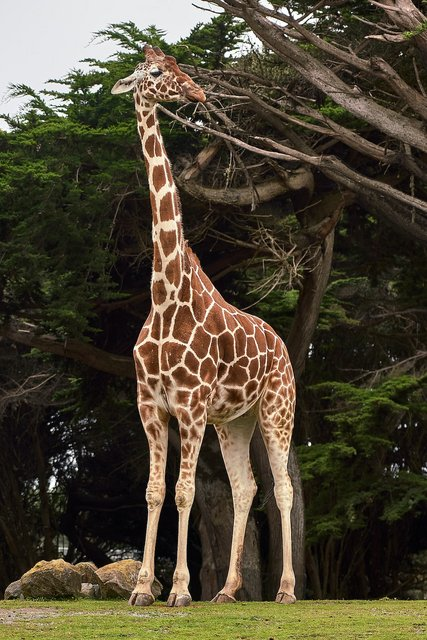

In [32]:
Image.fromarray(ds.images[1].numpy())

#**Step 5**: *Visualizing Datasets*

One of Deep Lake's core features is to enable users to visualize and interpret large amounts of data. Let's load the COCO dataset, which is one of the most popular datasets in computer vision.

In [33]:
import deeplake

ds = deeplake.load('hub://activeloop/coco-train')

-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/coco-train



|

hub://activeloop/coco-train loaded successfully.



/usr/local/lib/python3.10/dist-packages/deeplake/api/dataset.py:762: UserWarning: Dataset has more than 20 tensors. Skipping integrity check. Specify `check_integrity=True` to perform integrity check.
  warnings.warn(



The tensor layout for this dataset can be inspected using:

In [34]:
ds.summary()

Dataset(path='hub://activeloop/coco-train', read_only=True, tensors=['areas', 'boxes', 'categories', 'images', 'images_meta', 'iscrowds', 'masks', 'pose/boxes', 'pose/categories', 'pose/keypoints', 'pose/masks', 'pose/super_categories', 'stuff/areas', 'stuff/boxes', 'stuff/categories', 'stuff/iscrowds', 'stuff/masks', 'stuff/super_categories', 'super_categories'])

         tensor              htype                   shape                dtype  compression
        -------             -------                 -------              -------  ------- 
         areas              generic              (118287, 0:93)          uint32    None   
         boxes                bbox             (118287, 0:93, 4)         float32   None   
       categories         class_label            (118287, 0:93)          uint32    None   
         images              image       (118287, 51:640, 59:640, 1:3)    uint8    jpeg   
      images_meta             json                (118287, 1)              str     N

The dataset can be [visualized in the UI](https://app.activeloop.ai/activeloop/coco-train), or using an iframe in a jupyter notebook. If you don't already have flask and ipython installed, make sure to install Deep Lake using `pip install deeplake[visualizer]`.

In [35]:
ds.visualize()

HINT: Please forward the port - 60201 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


**Note:** Visualizing datasets in [Activeloop UI](https://app.activeloop.ai/) will unlock more features and faster performance compared to visualization in Jupyter notebooks.

##Visualizing your own datasets

Any Deep Lake dataset can be visualized using the methods above as long as it follows the conventions necessary for the visualization engine to interpret and parse the data. These conventions [are explained here](https://docs.activeloop.ai/dataset-visualization).

# **Step 6**: _Using Activeloop Storage_

_Storing and loading datasets from Activeloop Storage._

## Register and Authenticate

You can store your Deep Lake Datasets with Activeloop by first creating an account in the [Deep Lake App](https://app.activeloop.ai/).

Then should set the environmental variable `ACTIVELOOP_TOKEN` in your environment:

In [ ]:
import os
import getpass

os.environ['ACTIVELOOP_TOKEN'] = getpass.getpass()

You can then access or create Deep Lake Datasets by passing the Activeloop path to methods such as `deeplake.load()`, `deeplake.empty()`, and others.

In [ ]:
import deeplake

org_id = <your_org> # You already have an org that shares your username
dataset_name = <dataset_name>

ds = deeplake.dataset(f"hub://{org_id}/{dataset_name}")

**Note**: When you create an account in Activeloop, a default organization is created that has the same name as your username. You can also create other organization that represent companies, teams, or other collections of multiple users.

Public datasets such as `hub://activeloop/mnist-train` can be accessed without logging in.

# **Step 7**: _Connecting Deep Lake Datasets to ML Frameworks_

_Connecting Deep Lake Datasets to machine learning frameworks such as PyTorch and TensorFlow._

Deep Lake Datasets can be connected to popular ML frameworks such as PyTorch and TensorFlow using minimal boilerplate code. Our methods enable you to train models while streaming data from the cloud without bottlenecking the training process!

## PyTorch

There are two syntaxes that can be used to train models in Pytorch using Deep Lake datasets:


1.   **Deep Lake Data Loaders** are highly-optimized and unlock the fastest streaming and shuffling using Deep Lake's internal shuffling method. However, they do not support custom sampling or fully-random shuffling that is possible using PyTorch datasets + data loaders.
2.   **Pytorch Datasets + Data Loaders** enable all the customizability supported by PyTorch. However, they have highly sub-optimal streaming using Deep Lake datasets and may result in 5X+ slower performance compared to using Deep Lake data loaders.

### **Using Deep Lake Data Loaders**

**Best option for fast streaming!**


The fastest streaming of data to GPUs using PyTorch is achieved using Deep Lake's built-in PyTorch dataloaders `ds.pytorch()` (OSS Dataloader written in Python) or `ds.dataloader().pytorch()` (C++ and accessible to registered users). If your model training is highly sensitive to the randomization of the input data, please pre-shuffle the data, or explore our writeup on [shuffling in ds.pytorch()](https://docs.activeloop.ai/how-it-works/shuffling-in-ds.pytorch).

In [ ]:
import deeplake
from torchvision import datasets, transforms, models

ds = deeplake.dataset('hub://activeloop/cifar100-train') # Deep Lake Dataset

The transform parameter in `ds.pytorch()` is a dictionary where the `key` is the tensor name and the `value` is the transformation function that should be applied to that tensor. If a specific tensor's data does not need to be returned, it should be omitted from the keys. If a tensor's data does not need to be modified during preprocessing, the transformation function is set as `None`.

#### Transform syntax #1 - For independent transforms per tensor

The transform parameter in `ds.pytorch()` is a dictionary where the key is the tensor name and the value is the transformation function for that tensor. If a tensor's data does not need to be returned, the tensor should be omitted from the keys. If a tensor's data does not need to be modified during preprocessing, the transformation function for the tensor is set as `None`.

In [ ]:
tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

#PyTorch Dataloader
dataloader= ds.pytorch(batch_size = 16, num_workers = 2,
    transform = {'images': tform, 'labels': None}, shuffle = True)

#### Transform syntax #2 - For complex or dependent transforms per tensor

Transform are sometimes more complex where the same transform might need to be applied to all tensors, or tensors need to be combined in a transform. In this case, you can use the syntax below to perform the exact same transform as above:

In [ ]:
def transform(sample_in):
    return {'images': tform(sample_in['images']), 'labels': sample_in['labels']}

#OSS PyTorch Dataloader
dataloader_oss = ds.pytorch(batch_size = 16, num_workers = 1,
    transform = transform, shuffle = True)


#C++ PyTorch Dataloader
dataloader_cpp= ds.dataloader().pytorch(num_workers = 1).transform(transform = transform).batch(batch_size = 16).shuffle(shuffle = True)

**Note:** Some datasets such as imagenet contain both grayscale and color images, which can cause errors when the transformed images are passed to the model. To convert only the grayscale images to color format, you can add this Torchvision transform to your pipeline:

In [ ]:
# transforms.Lambda(lambda x: x.repeat(int(3/x.shape[0]), 1, 1))

### **Using PyTorch Datasets + Data Loaders**

**Best option for full customizability.**

Deep Lake datasets can be integrated in the PyTorch Dataset class by passing the `ds` object to the PyTorch Dataset's constructor and pulling data in the `__getitem__` method using `self.ds.image[ids].numpy()`:

In [ ]:
from torch.utils.data import DataLoader, Dataset

class ClassificationDataset(Dataset):
    def __init__(self, ds, transform = None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = self.ds.images[idx].numpy()
        label = self.ds.labels[idx].numpy(fetch_chunks = True).astype(np.int32)

        if self.transform is not None:
            image = self.transform(image)

        sample = {"images": image, "labels": label}

        return sample

**Note:** When loading data sequentially, or when randomly loading samples from a tensor that fits into the cache (such as `class_labels`) it is recommended to set `fetch_chunks = True`. This increases the data loading speed by avoiding separate requests for each individual sample. This is not recommended when randomly loading large tensors, because the data is deleted from the cache before adjacent samples from a chunk are used.

The PyTorch dataset + data loader is instantiated using the built-in PyTorch functions:

In [ ]:
dataset_pytorch = ClassificationDataset(ds, transform = tform)

dataloader_pytorch = DataLoader(dataset_pytorch, batch_size = 16, num_workers = 1, shuffle = True)

### **Iteration and Training**


You can iterate through both data loaders above using the exact same syntax. Loading the first batch of data using the Deep Lake data loader may take up to 30 seconds because the [shuffle buffer](https://docs.activeloop.ai/how-it-works/shuffling-in-ds.pytorch) is filled before any data is returned.

In [ ]:
for data in dataloader_oss:
    print(data)
    break

    # Training Loop

In [ ]:
for data in dataloader_cpp:
    print(data)
    break

    # Training Loop

In [ ]:
for data in dataloader_pytorch:
    print(data)
    break

    # Training Loop

For more information on training, check out the tutorial on [Training and Image Classification Model in PyTorch](https://docs.activeloop.ai/tutorials/training-models/training-an-image-classification-model-in-pytorch)

## TensorFlow

Deep Lake Datasets can be converted to TensorFlow Datasets using `ds.tensorflow()`. Downstream, functions from the `tf.Data` API such as map, shuffle, etc. can be applied to process the data before training.

In [ ]:
ds # Deep Lake Dataset object, to be used for training
ds_tf = ds.tensorflow() # A TensorFlow Dataset

# **Step 8**: _Parallel Computing_

_Running computations and processing data in parallel._

Deep Lake enables you to easily run computations in parallel and significantly accelerate your data processing workflows. This example primarily focuses on parallel dataset uploading, and other use cases such as dataset transformations can be found in [this tutorial](https://docs.activeloop.ai/tutorials/data-processing-using-parallel-computing).

Parallel compute using Deep Lake has two core elements: #1. defining a function or pipeline that will run in parallel and #2. evaluating it using the appropriate inputs and outputs. Let's start with #1 by defining a function that processes files and appends their data to the labels and images tensors.

**Defining the parallel computing function**

The first step for running parallel computations is to define a function that will run in parallel by decorating it using `@deeplake.compute`. In the example below, `file_to_hub` converts data from files into Deep Lake format, just like in **Step 2: Creating Deep Lake Datasets Manually**. If you have not completed Step 2, please complete the section that downloads and unzips the *animals* dataset

In [ ]:
import deeplake
from PIL import Image
import numpy as np
import os

@deeplake.compute
def file_to_hub(file_name, sample_out, class_names):
    ## First two arguments are always default arguments containing:
    #     1st argument is an element of the input iterable (list, dataset, array,...)
    #     2nd argument is a dataset sample
    # Other arguments are optional

    # Find the label number corresponding to the file
    label_text = os.path.basename(os.path.dirname(file_name))
    label_num = class_names.index(label_text)

    # Append the label and image to the output sample
    sample_out.append({"labels": np.uint32(label_num),
                       "images": deeplake.read(file_name)})

    return sample_out

In all functions decorated using `@deeplake.compute`, the first argument must be a single element of any input iterable that is being processed in parallel. In this case, that is a filename `file_name`, becuase `file_to_hub` reads image files and populates data in the dataset's tensors.

The second argument is a dataset sample `sample_out`, which can be operated on using similar syntax to dataset objects, such as `sample_out.append(...)`, `sample_out.extend(...)`, etc.

The function decorated using `@deeplake.compute` must return `sample_out`, which represents the data that is added or modified by that function.

**Executing the transform**

To execute the transform, you must define the dataset that will be modified by the parallel computation.

In [ ]:
ds = deeplake.empty('./animals_dl_transform') # Creates the dataset

Next, you define the input iterable that describes the information that will be operated on in parallel. In this case, that is a list of files `files_list` from the animals dataset in Step 2.

In [ ]:
# Find the class_names and list of files that need to be uploaded
dataset_folder = './animals'

class_names = os.listdir(dataset_folder)

files_list = []
for dirpath, dirnames, filenames in os.walk(dataset_folder):
    for filename in filenames:
        files_list.append(os.path.join(dirpath, filename))

You can now create the tensors for the dataset and **run the parallel computation** using the `.eval` syntax. Pass the optional input arguments to `file_to_hub`, and we skip the first two default arguments `file_name` and `sample_out`.

The input iterable `files_list` and output dataset `ds` is passed to the `.eval` method as the first and second argument respectively.

In [ ]:
with ds:
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
    ds.create_tensor('labels', htype = 'class_label', class_names = class_names)

    file_to_hub(class_names=class_names).eval(files_list, ds, num_workers = 2)

In [ ]:
Image.fromarray(ds.images[0].numpy())

Congrats! You just created a dataset using parallel computing! 🎈

# **Step 9**: _Dataset Version Control_

*Managing changes to your datasets using Version Control.*

Deep Lake dataset version control allows you to manage changes to datasets with commands very similar to Git. It provides critical insights into how your data is evolving, and it works with datasets of any size!

Let's check out how dataset version control works in Deep Lake! If you haven't done so already, please download and unzip the *animals* dataset from **Step 2**.

First let's create a Deep Lake dataset in the `./version_control_hub` folder.

In [ ]:
import deeplake
import numpy as np
from PIL import Image

# Set overwrite = True for re-runability
ds = deeplake.dataset('./version_control_hub', overwrite = True)

# Create a tensor and add an image
with ds:
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
    ds.images.append(deeplake.read('./animals/cats/image_1.jpg'))

The first image in this dataset is a picture of a cat:

In [ ]:
Image.fromarray(ds.images[0].numpy())

##Commit

To commit the data added above, simply run `ds.commit`:


In [ ]:
first_commit_id = ds.commit('Added image of a cat')

print('Dataset in commit {} has {} samples'.format(first_commit_id, len(ds)))

Next, let's add another image and commit the update:

In [ ]:
with ds:
    ds.images.append(deeplake.read('./animals/dogs/image_3.jpg'))

second_commit_id = ds.commit('Added an image of a dog')

print('Dataset in commit {} has {} samples'.format(second_commit_id, len(ds)))

The second image in this dataset is a picture of a dog:

In [ ]:
Image.fromarray(ds.images[1].numpy())

##Log

The commit history starting from the current commit can be show using `ds.log`:


In [ ]:
log = ds.log()

This command prints the log to the console and also assigns it to the specified variable log. The author of the commit is the username of the [Activeloop account](https://docs.activeloop.ai/getting-started/using-activeloop-storage) that logged in on the machine.

##Branch

Branching takes place by running the `ds.checkout` command with the parameter `create = True`. Let's create a new branch `dog_flipped`, flip the second image (dog), and create a new commit on that branch.

In [ ]:
ds.checkout('dog_flipped', create = True)

with ds:
    ds.images[1] = np.transpose(ds.images[1], axes=[1,0,2])

flipped_commit_id = ds.commit('Flipped the dog image')

The dog image is now flipped and the log shows a commit on the `dog_flipped` branch as well as the previous commits on `main`:

In [ ]:
Image.fromarray(ds.images[1].numpy())

In [ ]:
ds.log()

##Checkout

A previous commit of branch can be checked out using `ds.checkout`:

In [ ]:
ds.checkout('main')

Image.fromarray(ds.images[1].numpy())

As expected, the dog image on `main` is not flipped.

## Diff

Understanding changes between commits is critical for managing the evolution of datasets. Deep Lake's `ds.diff` function enables users to determine the number of samples that were added, removed, or updated for each tensor. The function can be used in 3 ways:

In [ ]:
ds.diff() # Diff between the current state and the last commit

In [ ]:
ds.diff(first_commit_id) # Diff between the current state and a specific commit

In [ ]:
ds.diff(second_commit_id, first_commit_id) # Diff between two specific commits

##HEAD Commit


Unlike Git, Deep Lake's dataset version control does not have a local staging area because all dataset updates are immediately synced with the permanent storage location (cloud or local). Therefore, any changes to a dataset are automatically stored in a HEAD commit on the current branch. This means that the uncommitted changes do not appear on other branches, and uncommitted changes are visible to all users.

**Let's see how this works:**

You should currently be on the `main` branch, which has 2 samples. Let's adds another image:


In [ ]:
print('Dataset on {} branch has {} samples'.format('main', len(ds)))

with ds:
    ds.images.append(deeplake.read('./animals/dogs/image_4.jpg'))

print('After updating, the HEAD commit on {} branch has {} samples'.format('main', len(ds)))

The 3rd sample is also an image of a dog:

In [ ]:
Image.fromarray(ds.images[2].numpy())

Next, if you checkout `dog_flipped` branch, the dataset contains 2 samples, which is sample count from when that branch was created. Therefore, the additional uncommitted third sample that was added to the `main` branch above is not reflected when other branches or commits are checked out.

In [ ]:
ds.checkout('dog_flipped')

print('Dataset in {} branch has {} samples'.format('dog_flipped', len(ds)))

Finally, when checking our the `main` branch again, the prior uncommitted changes and visible and they are stored in the `HEAD` commit on `main`:

In [ ]:
ds.checkout('main')

print('Dataset in {} branch has {} samples'.format('main', len(ds)))

The dataset now contains 3 samples and the uncommitted dog image is visible:

In [ ]:
Image.fromarray(ds.images[2].numpy())

You can delete any uncommitted changes using the `reset` command below, which will bring the `main` branch back to the state with 2 samples.

In [ ]:
ds.reset()

In [ ]:
print('Dataset in {} branch has {} samples'.format('main', len(ds)))

##Merge


Merging is a critical feature for collaborating on datasets. It enables you to modify data on separate branches before making those changes available on the `main` branch, thus enabling you to experiment on your data without affecting workflows by other collaborators.

We are currently on the main branch where the picture of the dog is right-side-up.

In [ ]:
ds.log()

In [ ]:
Image.fromarray(ds.images[1].numpy())

We can merge the `dog_flipped` branch into `main` using the command below:

In [ ]:
ds.merge('dog_flipped')

After merging the `dog_flipped` branch, we observe that the image of the dog is flipped. The dataset log now has a commit indicating that a commit from another branch was merged to `main`.

In [ ]:
Image.fromarray(ds.images[1].numpy())

In [ ]:
ds.log()

Congrats! You just are now an expert in dataset version control!🎓

# **Step 10:** *Dataset Filtering*

Filtering and querying is an important aspect of data engineering because analyzing and utilizing data in smaller units is much more productive than executing workflows on all data all the time.

Queries can be performed in Deep Lake enables with user-defined functions, or they can be executed in the [Deep Lake App](https://app.activeloop.ai/) using our highly-performance SQL-style query language.

## Filtering using our SQL query language


[Deep Lake](https://app.activeloop.ai/) offers a highly-performant SQL-style query language that is built in C++ and is optimized for Deep Lake datasets. Queries and their results are executed and saved in the UI, and they can be accessed in Deep Lake using using the the Dataset Views API described below.
Full details about the query language are described in a [standalone tutorial](https://docs.activeloop.ai/enterprise-features/querying-datasets).

## Filtering with user-defined-functions

The first step for querying using UDFs is to define a function that returns a boolean depending on whether an input sample in a dataset meets the user-defined condition. In this example, we define a function that returns `True` if the labels for a tensor are in the desired `labels_list`. If there are inputs to the filtering function other than `sample_in`, it must be decorated with `@deeplake.compute`.

In [ ]:
import deeplake
from PIL import Image

# Let's create a local copy of the dataset (Explanation is in the next section)
ds = deeplake.deepcopy('hub://activeloop/mnist-train', './mnist-train-local')

In [ ]:
labels_list = ['0', '8'] # Desired labels for filtering

@deeplake.compute
def filter_labels(sample_in, labels_list):

    return sample_in.labels.data()['text'][0] in labels_list

The filtering function is executed using the `ds.filter()` command below, and it returns a `Dataset View` that only contains the indices that met the filtering condition (more details below). Just like in the Parallel Computing API, the sample_in parameter does not need to be passed into the filter function when evaluating it, and multi-processing can be specified using the `scheduler` and `num_workers` parameters.

In [ ]:
ds_view = ds.filter(filter_labels(labels_list), scheduler = 'threaded', num_workers = 0)

In [ ]:
print(len(ds_view))

**Note:** in most cases, multi-processing is not necessary for queries that involve simple data such as labels or bounding boxes. However, multi-processing significantly accelerates queries that must load rich data types such as images and videos.

## Dataset Views

A Dataset View is any subset of a Deep Lake dataset that does not contains all of the samples. It can be an output of a query, filtering function, or regular indexing like `ds[0:2:100]`.

**Note:** In the filtering example above, we copied mnist-train locally in order to gain write access to the dataset, which affects the saving of `Dataset Views`. With write access, the views are saved as part of the dataset. Without write access, views are stored elsewhere or in custom paths, and full details are available here. Users have write access to their own datasets, regardless of whether the datasets are local or in the cloud.

The data in the returned `ds_view` can be accessed just like a regular dataset.

In [ ]:
Image.fromarray(ds_view.images[0].numpy())

A `Dataset View` can be saved permanently using the method below, which stores its indices without copying the data:

In [ ]:
ds_view.save_view(message = 'Samples with 0 and 8')

**Note:** In order to maintain data lineage, Dataset Views are immutable and are connected to specific commits. Therefore, views can only be saved if the dataset has a commit and there are no uncommitted changes in the HEAD

Each `Dataset View` has a unique `id`, and views can be examined or loaded using:

In [ ]:
views = ds.get_views()

print(views)

In [ ]:
ds_view = views[-1].load()

# OR

# ds_view = ds.load_view(id)

In [ ]:
print(len(ds_view))

Congrats! You just learned to filter adn query data with Deep Lake! 🎈